# Lesson 37: Algorithmic complexity: the longest common subsequence

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l37_lcs.ipynb).*

In [82]:
import itertools
import random

import numpy as np

# This is how we import the module of Matplotlib we'll be using
import matplotlib.pyplot as plt

# Seaborn makes plots pretty!
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Set JB's favorite Seaborn settings
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18, 
    'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)

So far, we have written some of our own simple programs with loops where necessary.  Most of the tasks we've coded up have been pretty straight forward and there is a more or less obvious way to approach things.

For some problems, and many important ones, the **algorithm**, or procedure, used to do the desired computation is important.  A calculation done with one algorithm may be much much faster than when it is done with another.

Unless you are in the business of coming up with novel algorithms to solve your problem of interest, most of the algorithms you use in your work in biology will be those developed by someone else.  Nonetheless, it is important for you to understand what goes into algorithms and that there can by **huge** differences in computational time depending on the algorithm used.

## The longest common subsequence
As an illustration of this idea, we will work out an important algorithm in bioinformatics.  Our goal is to compute the length of the **longest common subsequence** (**LCS**) between two sequences.  A subsequence is a sequence that can be generated by deleting entries in the original sequence, but leaving the order unchanged.  For example, the subsequences of length three of `ATGC` are:

    ATG
    TGC
    ATC
    ATC

All subsequences contain one deletion.  There are four deletions we could choose, so there are four subsequences.  The LCS between two sequences is the subsequence(s) that both share that are the longest.  That is sort of a tautology, I guess, but you get the point.

The LCS is useful to compare two sequences.  Deletions and insertions are common throughout evolution, so the LCS give a good indication of how similar two sequences are, even if these insertions or deletions are present.

## Tests!
As we develop an algorithm to compute the LCS between two subsequences, we should write tests to make sure our algorithm gives the right answer.  Let's write some!  Whatever we call our function (we'll call a generic one `lcslen`), it should be called as `lcslen(seq1, seq2)` and return an integer.

In [6]:
def test_lcslen(lcslen):
    """Test a given function to computing LCS"""
    # Define test sequences
    seq1 = 'abcd'
    seq2 = 'abcdefg'
    seq3 = 'adef'
   
    assert lcslen('', '') == 0
    assert lcslen('', seq1) == 0
    assert lcslen(seq1, seq1) == 4
    assert lcslen(seq1, seq2) == 4
    assert lcslen(seq1, seq3) == 2
    assert lcslen(seq2, seq3) == 4

### Let's fail the test
Remember, under the principles of TDD, we need to fail the test first.  Our first attempt will be a naive implementation, so we'll call it `naive_lcslen()`.

In [7]:
def naive_lcslen(seq1, seq2):
    """
    Return length of longest common subsequence 
    between two subsequences.
    """
    
    return 0

And now we'll fail the test.

In [8]:
test_lcslen(naive_lcslen)

AssertionError: 

## Naive strategy
Thinking off the top of my head, I think the following seems like a reasonable algorithm.  Let $m$ be the length of `seq1` and $n$ be the length of `seq2`, with $m \ge n$.

1. Generate all subsequences of `seq1` that are length $n$.
2. See if any of these subsequences match `seq2`.
3. Generate all subsequences of `seq1` and of `seq2` of length $q = n - 1$
4. Compare these to sets of subsequences and see if any of the subsequences match.
5. Go to step 3, except decrement $q$ by one each cycle until we get to $q = 1$.
6. If no common subsequence is found when $q=1$, return 0.

### Finding all subsequences
To implement this strategy, we need a function to generate all subsequences of a given length.  Its call signature will be

    allsubseqs(seq, n)

and it will return a **`set`** of all of the subsequences.  A **`set`** is a built-in Python data type that is like a list, but only contains the unique elements.  It is unordered and immutable.

It turns out that we don't need to write this function!  The [`itertools.combinations()`](https://docs.python.org/3.5/library/itertools.html#itertools.combinations) function in the standard library gives this functionality.  We don't need to test this (since the standard library is trustworthy; carefully unit tested), so we can just use it.

In [12]:
def allsubseqs(seq, n):
    """Return a set containing all subsequences of length n"""
    return set(itertools.combinations(seq, n))

Let's give it a try.

In [22]:
allsubseqs('abcd', 3)

{('a', 'b', 'c'), ('a', 'b', 'd'), ('a', 'c', 'd'), ('b', 'c', 'd')}

The resulting set has tuples as elements, but that's ok, since we can just compare tuples to other tuples.

### Implementation of naive strategy
Now we'll code up the main LCS function according to the algorithm we laid out in words.

In [131]:
def naive_lcslen(seq1, seq2, return_lcs=False):
    """Naive implementation of LCS length calculator."""
    
    # For convenience, make sure seq1 is longer than seq2
    if len(seq1) < len(seq2):
        seq1, seq2 = seq2, seq1
        
    # Initialize length of subsequence to consider
    q = len(seq2)
    
    # Compare subsequences for a match
    while q > 0:
        # Generate subsequences
        seq1_subseqs = allsubseqs(seq1, q)
        seq2_subseqs = allsubseqs(seq2, q)
        
        # Compute the intersections (common subsequences)
        lcs_set = seq1_subseqs.intersection(seq2_subseqs)

        # If the intersection is non-empty, we've found the LCS
        if len(lcs_set) > 0:
            break
        
        # Decrement length of subsequence
        q -= 1
        
    # If we want to return the LCS, compute it
    if return_lcs:
        return q, tuple([''.join(lcs) for lcs in lcs_set])
    else:
        return q

Notice that since we end up computing the actual LCS, and not just its length, we can actually return all of the LCSs (since the LCS is not necessarily unique) we like.  I therefore put in the `return_lcs` kwarg and return the LCS as well.  Now, let's run our test on it to make sure it works.

In [132]:
test_lcslen(naive_lcslen)

Hurray!  It passed.  Now, let's try it with some biological-type sequences.  We typically compare protein sequences, since we don't want frame shifts.  In an earlier homework, you wrote a random protein sequence generator.

In [133]:
def random_protein_sequence(n):
    """Generate a random protein sequence."""
    seq_list = [None] * n
    for i in range(n):
        seq_list[i] = random.choice('ACDEFGHIKLMNPQRSTVWY')

    return ''.join(seq_list)

Let's use that to generate some test sequences and find the LCS.  Actually, we only report on of the possibly many LCS, since it is not guarenteed to be unique.

In [134]:
# Seed for reproducibility
random.seed(42)

# Generate random sequences and compute LCS
seq1 = random_protein_sequence(20)
seq2 = random_protein_sequence(24)
len_lcs, lcs = naive_lcslen(seq1, seq2, return_lcs = True)

print("""
      seq1: {seq1:s}
      seq2: {seq2:s}
LCS length: {len_lcs:d}
""".format(seq1=seq1, seq2=seq2, len_lcs=len_lcs))

print("The LCS(s) is/are:", lcs)


      seq1: EAKIIFEVDWQCADHITYAV
      seq2: HVQIRWKAGQMKFHMEDPENNYKC
LCS length: 6

The LCS(s) is/are: ('AKFEDY', 'AKFEDC')


### The naive implementation is sloooooow
Wow.  That took a while, and we were only comparing 20-some bases.  Why?

Let's think about what the algorithm is doing, and let's think about it in the worst-case scenario in which it does not find an LCS at all, meaning it has to go all the way through the while loop.  At each iteration in the **`while`** loop, the `allsubseqs` function computes all subsequences of a given length.  As you might guess from the name of the `itertools.combintations()` function, there are

\begin{align}
\begin{pmatrix}
n\\k
\end{pmatrix} = \frac{n!}{(n-k)! k!}
\end{align}

subsequences of length $k$ for a sequence of length $n$.  You can also see this by counting how many deletions you need to make to get a subsequence.  There are

\begin{align}
\begin{pmatrix}
n\\n-k
\end{pmatrix} = \begin{pmatrix}
n\\k
\end{pmatrix}
\end{align}

such deletions.  This number of cominbations can be large.  For example, to find all subsequence of length 10 in a sequence of length 20, we would have to generate

\begin{align}
\begin{pmatrix}
20\\10
\end{pmatrix} = 184,756
\end{align}

subsequences (twice) and then compare them.  In the worst case, the total number of subsequences you would have to generate is

\begin{align}
2 \sum_{k=0}^n \begin{pmatrix}
n\\k
\end{pmatrix} = 2^{n+1}.
\end{align}

This can be huge!  For typical protein sequences of length $n = 300$, this amounts to $10^{90}$ generated subsequences!  The biggest set of these has $10^{88}$ subsequences in it.  This is more than the number of atoms in the observable universe.  We could never even store the subsequences!

## Time complexity
Because the size of the problem, $n$, appears in the exponent in the number of operations required for our naive algorithm, it is said to have **exponential timem complexity**.  Exponential time algorithms are sometimes necessary, but many problems can be solved much more efficiently with more clever algorithms.

## Dynamic programming solution
Let's take a new strategy.  We'll do a divide-and-conquer strategy.  We'll start small.  We start be considering the tiniest substring for each sequence and compare them. Note the difference: a sub*string* does not have any deletions; a sub*sequence* does.  We'll then keep comparing longer and longer substrings, computing the length of the LCS, until we get to the whole sequence of each.  The hope is that we can use the information of smaller substrings as we build up to avoid re-computing things.  Lets map out our algorithm.

>We have an $m+1 \times n+1$ matrix called `lcs_mat`.  Entry `lcs_mat[i, j]` stores the length of the LCS for substrings `seq1[0:i]` and `seq2[0:j]`.  
>
>Let's say we are looking at entry $(i, j)$, as we have already computed the entries for all rows less than $i$ and all columns less than $j$.  
>
>Now, if `seq1[i-1] == seq2[j-1]`, we know that 

    >        lcs_mat[i,j] = lcs_mat[i-1, j-1] + 1.

>Why?  Because we just matched another character, so we extend the subsequence length by one.

>But, if `seq1[i-1] != seq2[j-1]`, we cannot have a longer common subsequence than we have already detected.  Either the longest common subsequence of the substrings (`seq1[0:i-1]`, `seq2[0:j]`) or of (`seq1[0:i]`, `seq2[0:j-1]`) is still the longest.

> The cool thing is that we can trivially compute the first row and column of `lcs_mat`.  They're all zeros, since no substring can match.  So, we just keep moving `i` and `j` forward, checking to see if there is a sequence match at positions `i,j` or using results we already computed.

An example `lcs_mat` is shown below.  We first fill out the first row and first column, and then proceed going left to right one row at a time.


 |$\emptyset$ | `a` | `b` | `c` | `d`|
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
$\emptyset$| 0| 0| 0| 0|0
`b` | 0| 0| 1|0 |0
`b` | 0| 0| 1| 1|1
`c` | 0| 0| 1| 2|2

This style of building up a solution to a big problem from smaller subproblems is called **dynamic programming**.  The name is an [odd historical artifact](https://en.wikipedia.org/wiki/Dynamic_programming#History).  It's not especially "dynamic," it's just a name.  Let's code this up in Python!

In [135]:
def dp_lcslen(seq1, seq2):
    """Length of LCS using a dynamic program."""

    # Initialize matrix of substring LCSs.
    lcs_mat = np.zeros((len(seq1)+ 1, len(seq2) + 1), dtype=int)
    
    # Build matrix, left to right, row by row
    for i in range(1, len(seq1)+1):
        for j in range(1, len(seq2)+1):
            if seq1[i-1] == seq2[j-1]:
                lcs_mat[i, j] = lcs_mat[i-1, j-1] + 1
            else:
                lcs_mat[i, j] = max(lcs_mat[i-1, j], lcs_mat[i, j-1])

    return lcs_mat[-1,-1]

Let's run it through the unit test!

In [136]:
test_lcslen(dp_lcslen)

Excellent!  It tests out!  Now, let's try it out on our protein sequences.

In [137]:
dp_lcslen(seq1, seq2)

6

We got the correct answer, and it was way faster!

### Time complexity of the dynamic program
To get the time complexity of the dynamic program, we again think about how many operations we need to do.  We build a matrix which has about $n^2$ entries (where we assume $m \approx n$.  Each entry consists of a simple comparison of two characters and then either an addition of `1` or fetching another value.  So, we really only have roughly $n^2$ operations to achieve the result.  So, the dynamic programming algorithm has a time complexity of $n^2$.  Let's compare how long things will take with the respective algorithms as a function of the size of the problem, $n$.

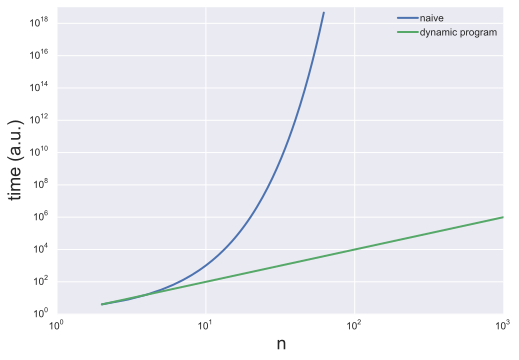

In [100]:
# Problem size
n = np.arange(2, 1001)

# Plot the complexity
plt.loglog(n, 2**n)
plt.loglog(n, n**2)

# Label plot
plt.xlabel('n')
plt.ylabel('time (a.u.)')
plt.legend(('naive', 'dynamic program'), loc='upper right')

We have no prayer of computing large sequences using the naive approach.  The dynamic program make the problem feasable.

### Getting the LCS
Our dynamic program is really fast for finding the length of the LCS, but what about the LCS itself?  In many dynamicm programs, we can do **backtracking**, where we go back through the algorithm and extract information.  We can do the same with the LCS algorithm.  We start at the bottom of the `lcs_mat`, and then work backwards, adding a character whenever it was added in the LCS length algorithm.

In [140]:
def dp_lcslen(seq1, seq2, return_lcs=False):
    """Length of LCS using a dynamic program."""

    # Initialize matrix of substring LCSs.
    lcs_mat = np.zeros((len(seq1)+ 1, len(seq2) + 1), dtype=int)
    
    # Build matrix, left to right, row by row
    for i in range(1, len(seq1)+1):
        for j in range(1, len(seq2)+1):
            if seq1[i-1] == seq2[j-1]:
                lcs_mat[i, j] = lcs_mat[i-1, j-1] + 1
            else:
                lcs_mat[i, j] = max(lcs_mat[i-1, j], lcs_mat[i, j-1])
                
    if return_lcs:
        lcs = ''
        i = len(seq1)
        j = len(seq2)
        while i != 0 and j != 0:
            if lcs_mat[i,j] == lcs_mat[i-1, j]:
                i -= 1
            elif lcs_mat[i, j] == lcs_mat[i, j-1]:
                j -= 1
            else:
                lcs = seq1[i-1] + lcs
                i -= 1
                j -= 1
        return lcs_mat[-1, -1], lcs
    else:
        return lcs_mat[-1,-1]


Let's give it a whirl!

In [145]:
dp_lcslen(seq1, seq2, True)

(6, 'AKFEDC')

The dynamic program only returns one of the LCSs, since we did not enumerate them all.

## Examples of dynamic programs
This style of building up a solution to a big problem from smaller subproblems is called **dynamic programming**.  It is pervasive in biology.  Here are some examples of problems that use dynamic programming.

* Global alignment (Needleman-Wunsch)
* Local alignment (Smith-Waterman)
* Some multiple sequence alignment algorithms (though most use other methods)
* RNA structure prediction
* Structural alignment (such as SSAP)

## A word of warning about algorithmic development
In LCS example, we found that practical calculations the LCS length were impossible with our first algorithm because of time and storage limitations.  However, the algorithm *works*.  In general, when you are writing code, first get something that works.  That is, something that passes your unit tests and does what you want it to do.  *Then* decide if it needs optimization.  It is quite possible that a "naive" algorithm might be just find for your purposes.  If this is the case, don't optimize.  I think it's important to remember what Donald Knuth, one of the great computer scientists of all time, said.

<div class="alert alert-info">
<center>"Premature optimization is the root of all evil."  --Donald Knuth</center>
</div>

This goes also for what language you write your code in.  Coding something up in Python or some other high level interpreted language is typically much easier than in a compiled language like C or Fortran.  You code is also more portable.  Only when you really need the speed should you go for one of those language.